In [2]:
from sae import SAE
import clip
import json
import os
import pandas as pd
from tqdm import tqdm
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sae1 = SAE("models/4096_512_TopKReLU_64_False_False_0.0_cc3m_ViT-B~16_train_image_2905954_512_None_v2.pth").cuda()
sae2 = SAE("models/4096_512_TopKReLU_64_False_False_0.0_cc3m_ViT-B~16_train_image_2905954_512_DcorLatent_42_20_000.pth").cuda()
clip_model, clip_prep = clip.load("ViT-B/16", device="cuda")

In [4]:
with open('imagenet100/Labels.json', 'r') as f:
    labels = json.load(f)

In [5]:
images = []

for label in os.listdir('imagenet100/val.X'):
    for filename in os.listdir(f'imagenet100/val.X/{label}'):
        images.append({
            'path': f'imagenet100/val.X/{label}/{filename}',
            'label': labels[label],
        })

df = pd.DataFrame(images)
df

,path,label
0,imagenet100/val.X/n01687978/ILSVRC2012_val_000...,agama
1,imagenet100/val.X/n01687978/ILSVRC2012_val_000...,agama
2,imagenet100/val.X/n01687978/ILSVRC2012_val_000...,agama
3,imagenet100/val.X/n01687978/ILSVRC2012_val_000...,agama
4,imagenet100/val.X/n01687978/ILSVRC2012_val_000...,agama
...,...,...
4995,imagenet100/val.X/n01739381/ILSVRC2012_val_000...,vine snake
4996,imagenet100/val.X/n01739381/ILSVRC2012_val_000...,vine snake
4997,imagenet100/val.X/n01739381/ILSVRC2012_val_000...,vine snake
4998,imagenet100/val.X/n01739381/ILSVRC2012_val_000...,vine snake


In [12]:
sae1_representations = []
sae2_representations = []
clip_representations = []
sae1_reconstructed = []
sae2_reconstructed = []
image_paths = []
metrics_all = []

for index, row in tqdm(df.iterrows(), total=len(df)):
    image_paths.append(row['path'])
    image = Image.open(row['path'])
    input = clip_prep(image).unsqueeze(0)

    with torch.no_grad():
        features = clip_model.encode_image(input.to('cuda'))
        post_reconstructed1, reconstructed1, full_latents1 = sae1(features.to(torch.float32).to('cuda'))
        post_reconstructed2, reconstructed2, full_latents2 = sae2(features.to(torch.float32).to('cuda'))
        
    clip_representations.append(features.cpu().flatten())
    sae1_representations.append(full_latents1.cpu().flatten())
    sae2_representations.append(full_latents2.cpu().flatten())
    sae1_reconstructed.append(post_reconstructed1.cpu().flatten())
    sae2_reconstructed.append(post_reconstructed2.cpu().flatten())

clip_representations = torch.stack(clip_representations)
sae1_representations = torch.stack(sae1_representations)
sae2_representations = torch.stack(sae2_representations)
sae1_reconstructed = torch.stack(sae1_reconstructed)
sae2_reconstructed = torch.stack(sae2_reconstructed)
clip_representations.shape, sae1_representations.shape, sae2_representations.shape

100%|██████████| 5000/5000 [01:17<00:00, 64.12it/s]


(torch.Size([5000, 512]), torch.Size([5000, 4096]), torch.Size([5000, 4096]))

In [15]:
concept_match_scores1 = np.load("namings/Concept_Interpreter_4096_512_TopKReLU_64_False_False_0.0_cc3m_ViT-B~16_train_image_2905954_512_None_v2_disect_ViT-B~16_-1_text_20000_512.npy")
concept_match_scores2 = np.load("namings/Concept_Interpreter_4096_512_TopKReLU_64_False_False_0.0_cc3m_ViT-B~16_train_image_2905954_512_DcorLatent_42_20_000_disect_ViT-B~16_-1_text_20000_512.npy")

In [16]:
with open('vocab/clip_disect_20k.txt', 'r') as f:
    vocab_names = [line.strip() for line in f.readlines()]
len(vocab_names)

20000

In [17]:
img_index1, neuron_index1 = torch.where(sae1_representations == sae1_representations.max())
img_index2, neuron_index2 = torch.where(sae2_representations == sae2_representations.max())

print(f"SAE 1 most active: {neuron_index1.item()} neuron in image {img_index1.item()}")
print(f"SAE 2 most active: {neuron_index2.item()} neuron in image {img_index2.item()}")

SAE 1 most active: 2201 neuron in image 4196
SAE 2 most active: 220 neuron in image 4037


In [18]:
def plot_orthogonality(sae_representations, img_index, conecpt_scores, title="SAE 1"):
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    fig.suptitle(title)
    top_10 = sae_representations[img_index].topk(10)
    names = [vocab_names[conecpt_scores[:, i].argmax()]+f"/{i}" for i in top_10.indices.cpu().numpy()]
    with torch.no_grad():
        clip_names = torch.cat([clip_model.encode_text(clip.tokenize(name).cuda()) for name in names])
        clip_names = torch.nn.functional.normalize(clip_names)
    heat_map = clip_names @ clip_names.T
    heat_map = heat_map.cpu().numpy()

    labels = names

    hmap = ax[1].imshow(heat_map, cmap='viridis')
    fig.colorbar(hmap, ax=ax[1])

    ax[1].set_xticks(ticks=range(10), labels=labels, rotation=45, ha='right')
    ax[1].set_yticks(ticks=range(10), labels=labels)

    ax[1].set_title("Cosine Similarity Heatmap")
    
    
    ax[0].imshow(Image.open(image_paths[img_index]).convert('RGB'))
    ax[0].axis('off')
    ax[0].set_title(f'Image {img_index}')
    ax[2].barh(range(10), top_10.values.cpu().numpy())
    ax[2].set_yticks(range(10))
    ax[2].set_yticklabels(names)
    ax[2].set_title(f'Top 10 SAE Concepts for Image {img_index}')
    plt.tight_layout()
    plt.show()

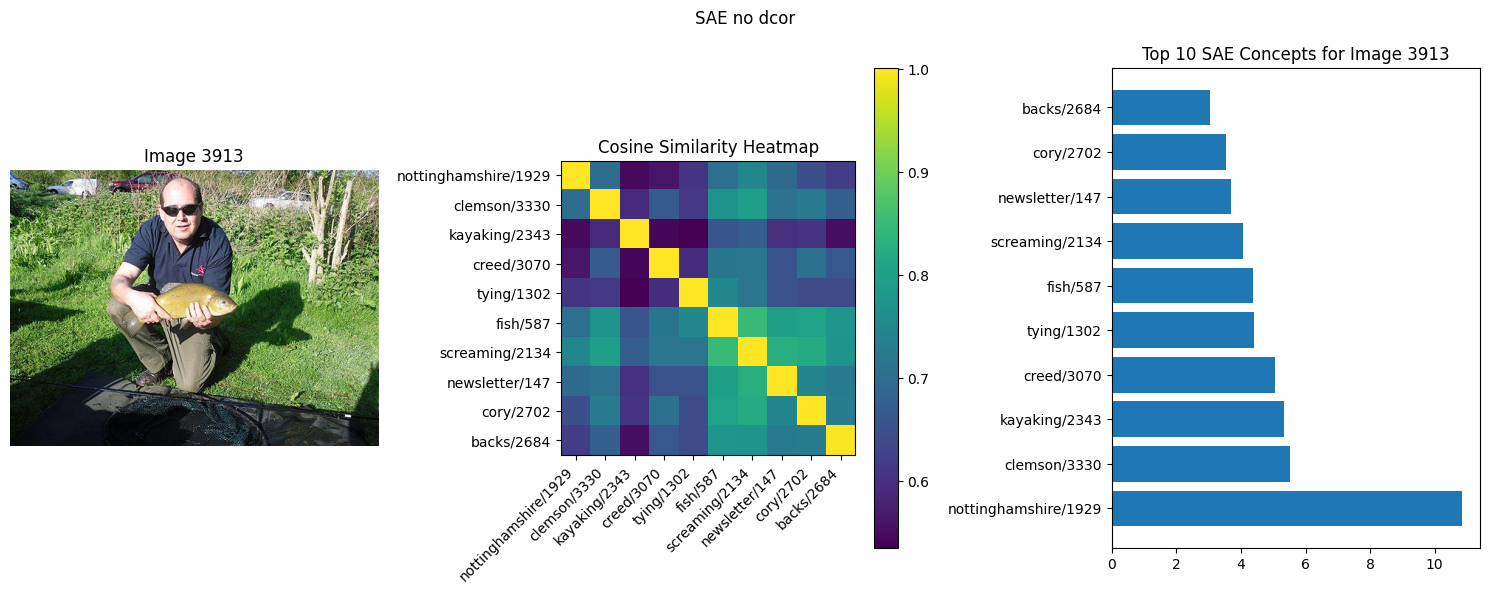

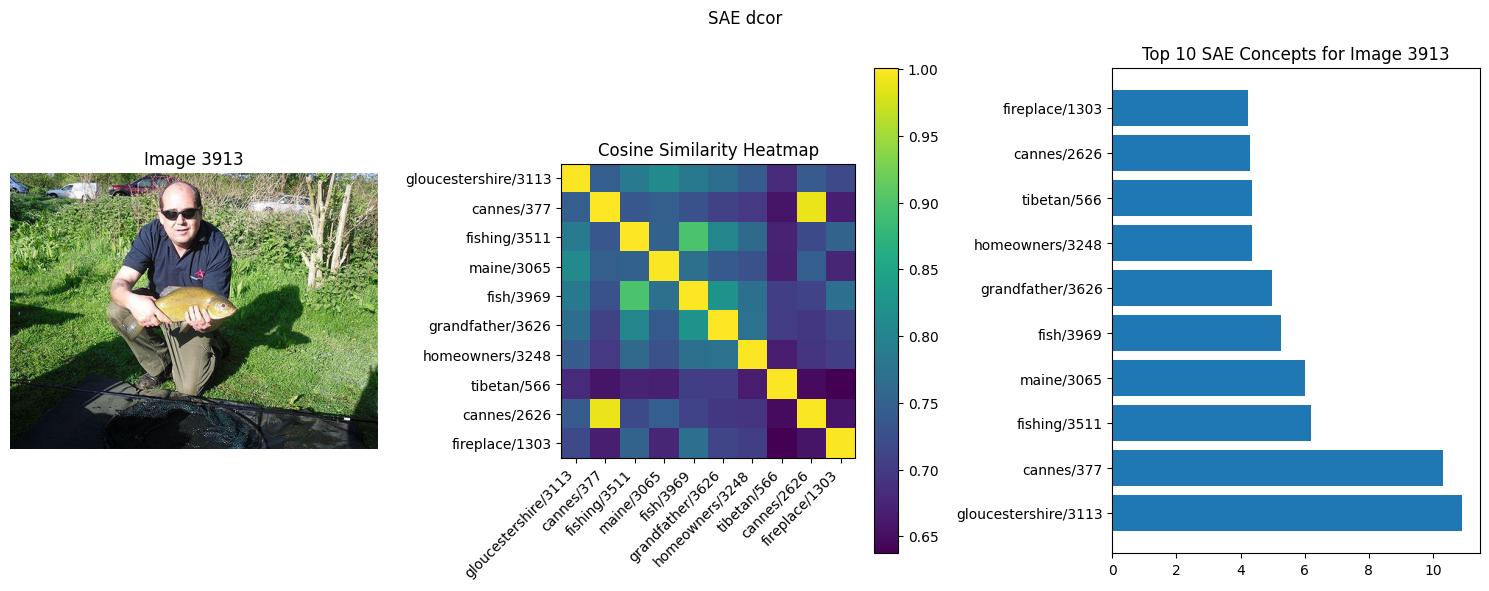

In [26]:
img_index = 3913
plot_orthogonality(sae1_representations, img_index, concept_match_scores1, "SAE no dcor")
plot_orthogonality(sae2_representations, img_index, concept_match_scores2, "SAE dcor")